In [29]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
%config InlineBackend.figure_format = 'png' 
%matplotlib inline
plt.style.use(style='fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)

### Load Data

In [30]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [31]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


### Data Preprocessing
Let's do our feature engineering, data exploring, and all things in between here

Let's get started

Skewness of the original intended feature: 1.3291026531678385
Skewness of transformed feature -0.03365667635294192


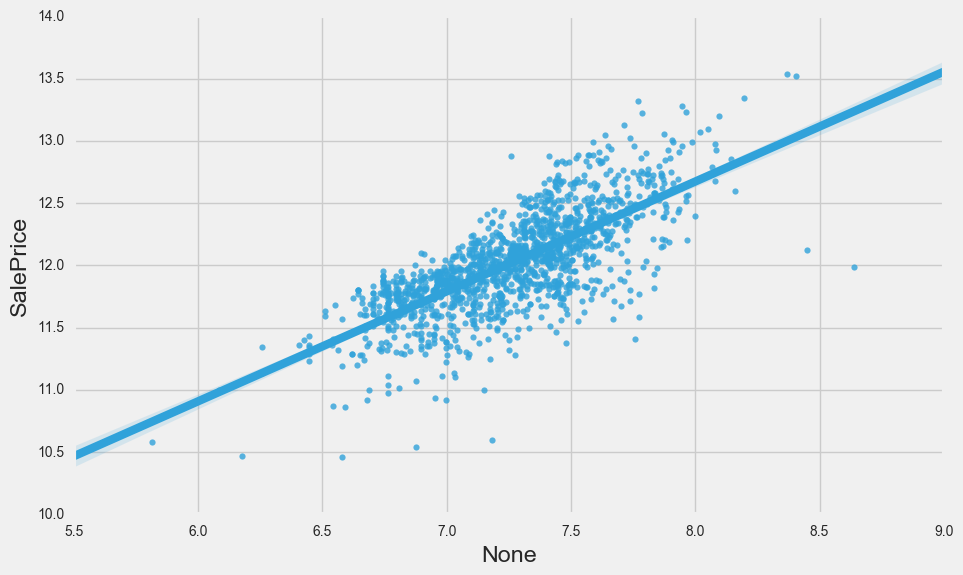

In [32]:
feat_ex = (train['1stFlrSF'] + train['2ndFlrSF']).copy()
print("Skewness of the original intended feature:",skew(feat_ex))
print("Skewness of transformed feature", skew(np.log1p(feat_ex)))
# Since it's skewed, let's try to take the log of it.
feat_ex = np.log1p(feat_ex)
# Plot
sns.regplot(x=(feat_ex), y=np.log1p(train['SalePrice']), data=train, order=1);

In [33]:
train['Total_Flr_Sf'] = np.log1p(train['1stFlrSF'] + train['2ndFlrSF'])
test['Total_Flr_Sf'] = np.log1p(test['1stFlrSF'] + test['2ndFlrSF'])

Let's try adding all of the sf columns into a combined one


Skewness of the original intended feature: 1.427345461344283
Skewness of transformed feature 0.022891569554582644


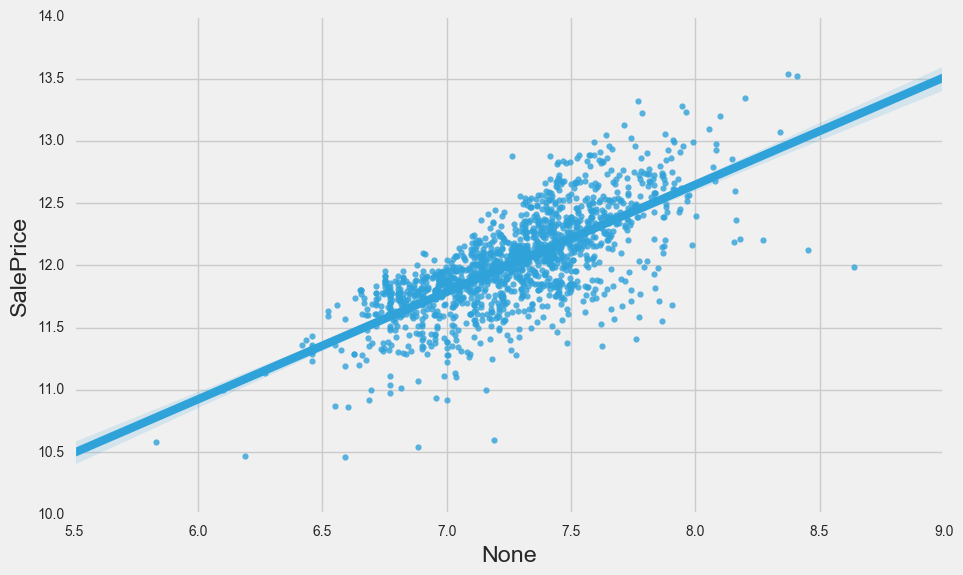

In [34]:
feat_ex = (train['Total_Flr_Sf'] + train['LowQualFinSF'] + train['GrLivArea']).copy()
print("Skewness of the original intended feature:",skew(feat_ex))
print("Skewness of transformed feature", skew(np.log1p(feat_ex)))

# Since it's skewed, let's try to take the log of it.
feat_ex = np.log1p(feat_ex)

#Plot
sns.regplot(x=(feat_ex), y=np.log1p(train['SalePrice']), data=train, order=1);

In [35]:
train['All_Liv_SF'] = np.log1p(train['Total_Flr_Sf'] + train['LowQualFinSF'] + train['GrLivArea'])
test['All_Liv_SF'] = np.log1p(test['Total_Flr_Sf'] + test['LowQualFinSF'] + test['GrLivArea'])

## Next Step

In [36]:
# get all features minus Id and SalePrice
feats = train.columns.difference(['Id','SalePrice'])

# Let's concatenate our train and test sets into one so we can apply transpforamtions and preprocessing techniques
# on both at the same time
all_data = pd.concat((train.loc[:,feats],
                      test.loc[:,feats]))

## Preprocessing Steps

* Transform features that are skewed into a more normal distribution using log(p+1)
* pd.Dummy() variables for categorical features
* Replace nans/null values

In [37]:
# But first, we log transform the target
train["SalePrice"] = np.log1p(train["SalePrice"])

### Transforms

In [38]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

### Get Dummies

In [39]:
# getting dummies for all features. 
all_data = pd.get_dummies(all_data)

### Do soemthing about Nans

In [40]:
all_data = all_data.fillna(all_data[:train.shape[0]].mean())

In [41]:
print(all_data.shape)
# creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice
print (X_train.shape)
print (X_test.shape)
print (y.shape)

(2919, 290)
(1460, 290)
(1459, 290)
(1460,)


## Train Model

In [42]:
from sklearn.cross_validation import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [43]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression, Perceptron

### Let's get to work using LassoCV

In [44]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(X_train, y)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

Mean: 0.123193616456
Min:  0.103475492047


In [45]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 113 variables and eliminated the other 177 variables


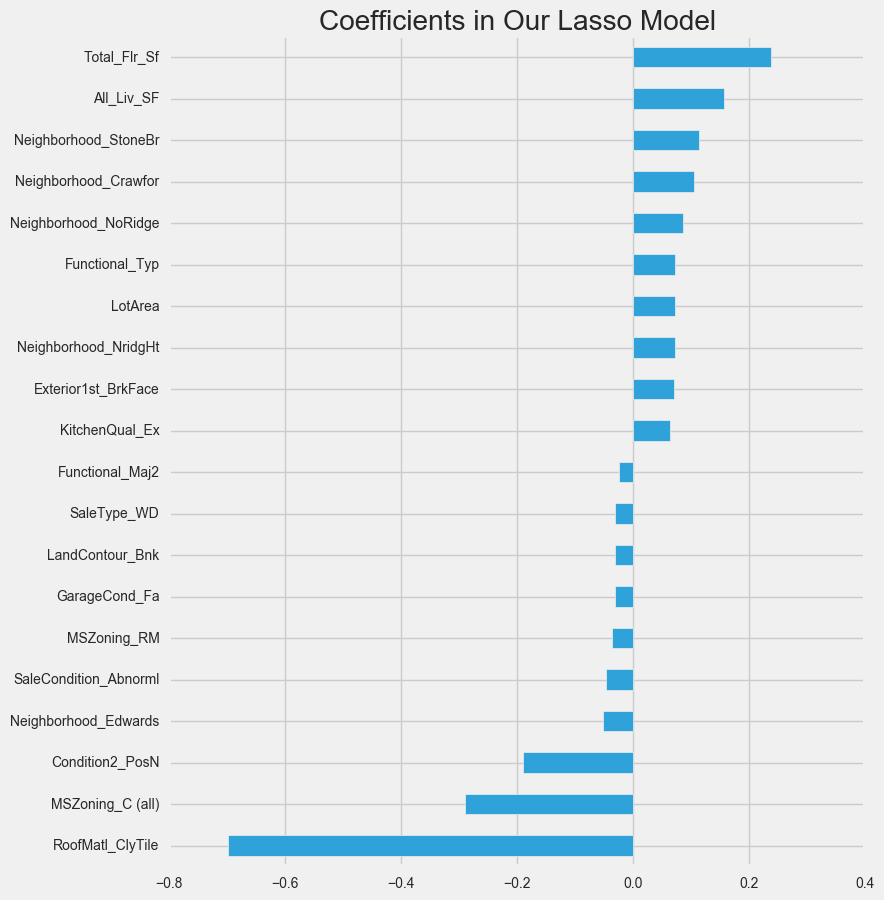

In [48]:
# plotting feature importances!
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients in Our Lasso Model")

In [47]:
# Let's make some predictions and submit it to the lb
test_preds = np.expm1(model_lasso.predict(X_test))
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission["SalePrice"] = test_preds
submission.to_csv("../output/submission8.csv", index=False)